In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Model, layers, models, optimizers, losses

In [17]:
dataset = pd.read_csv('data/HMF_theor.csv').drop(['Unnamed: 0'], axis=1)

x = dataset['log_10(mvir)'].values
y = dataset['n(>M)'].values

lcdm = pd.read_csv('data/lcdm_counts.dat').drop(['Unnamed: 0'], axis = 1)

In [18]:
lcdm

,log_10(M200c),counts,n(>M)
0,10.572196,773,0.028888
1,10.877562,717,0.022704
2,11.182927,689,0.016968
3,11.488293,625,0.011456
4,11.793659,372,0.006456
5,12.099025,221,0.003480
6,12.404391,107,0.001712
7,12.709756,46,0.000856
8,13.015122,35,0.000488
9,13.320488,12,0.000208


In [19]:
dataset

,log_10(mvir),n(>M)
0,1.000000e+10,2.543783e-01
1,1.122018e+10,2.298566e-01
2,1.258925e+10,2.077056e-01
3,1.412538e+10,1.876949e-01
4,1.584893e+10,1.696162e-01
...,...,...
95,5.623413e+14,1.997294e-06
96,6.309573e+14,1.556080e-06
97,7.079458e+14,1.199768e-06
98,7.943282e+14,9.146886e-07


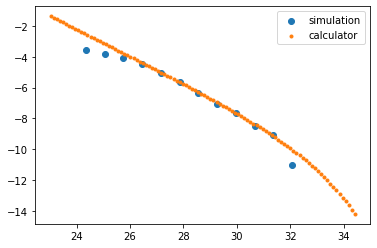

In [20]:
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='simulation')
plt.scatter(np.log(dataset['log_10(mvir)']), np.log(dataset['n(>M)']), label='calculator', marker='.')
plt.legend()

In [21]:
dataset = np.log(dataset)

In [34]:
np.max(dataset), np.min(dataset)

/home/isidro/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(log_10(mvir)    34.423647
 n(>M)           -1.368933
 dtype: float64,
 log_10(mvir)    23.025851
 n(>M)          -14.188168
 dtype: float64)

In [36]:
X = dataset.values[:, 0]
Y = dataset.values[:, 1]

xscaler = StandardScaler()
yscaler = StandardScaler()
# # fit scaler on data
xscaler.fit(X.reshape(-1, 1))
yscaler.fit(Y.reshape(-1, 1))
# # apply transform
X_sc = xscaler.transform(X.reshape(-1, 1))
Y_sc = yscaler.transform(Y.reshape(-1, 1))

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_sc, Y_sc, test_size=0.1, random_state=42)

In [26]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
#                                    min_delta=0.0,
#                                    patience=50.0,
#                                    restore_best_weights=True)]

In [38]:
def ann_model(ninput=1, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu',input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
#                   SGD(learning_rate=1e-4),#RMSprop(lr=0.001),
                        loss='mse',
                        metrics=['mse'])


#     test1_model.summary()
    return model

In [39]:
# dropout = grid_result.best_params_['dropout']
dropout = 0.5
# n_nodes1 = grid_result.best_params_['n_nodes1']
n_nodes1 = 100
# n_nodes2 = grid_result.best_params_['n_nodes2']
n_nodes2 = 100
# n_nodes3 = grid_result.best_params_['n_nodes3']
n_nodes3 = 100

In [40]:
neural_model = ann_model(n_nodes1=n_nodes1, n_nodes2=n_nodes2, n_nodes3=n_nodes3,
                        dropout=dropout)

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=2, 
                                         restore_best_weights=True)

lrdecay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               patience=2)
callbacks = [estop]

neural_model_history = neural_model.fit(X_train,
                                      y_train,
                                      epochs=500,
                                      batch_size=32,
                                      validation_data=(X_val,y_val),
                                      verbose=1)#, #callbacks=callbacks)



Epoch 1/500
3/3 [==============================] - 1s 44ms/step - loss: 0.9695 - mse: 0.9695 - val_loss: 0.8145 - val_mse: 0.8145
Epoch 2/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9305 - mse: 0.9305 - val_loss: 0.8028 - val_mse: 0.8028
Epoch 3/500
3/3 [==============================] - 0s 10ms/step - loss: 1.0440 - mse: 1.0440 - val_loss: 0.7911 - val_mse: 0.7911
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9895 - mse: 0.9895 - val_loss: 0.7794 - val_mse: 0.7794
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9563 - mse: 0.9563 - val_loss: 0.7683 - val_mse: 0.7683
Epoch 6/500
3/3 [==============================] - 0s 11ms/step - loss: 1.0205 - mse: 1.0205 - val_loss: 0.7576 - val_mse: 0.7576
Epoch 7/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8931 - mse: 0.8931 - val_loss: 0.7475 - val_mse: 0.7475
Epoch 8/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9713 - mse: 0.971

Epoch 64/500
3/3 [==============================] - 0s 10ms/step - loss: 0.2620 - mse: 0.2620 - val_loss: 0.1244 - val_mse: 0.1244
Epoch 65/500
3/3 [==============================] - 0s 10ms/step - loss: 0.2836 - mse: 0.2836 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 66/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2673 - mse: 0.2673 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 67/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2441 - mse: 0.2441 - val_loss: 0.1023 - val_mse: 0.1023
Epoch 68/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2662 - mse: 0.2662 - val_loss: 0.0957 - val_mse: 0.0957
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2547 - mse: 0.2547 - val_loss: 0.0895 - val_mse: 0.0895
Epoch 70/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2690 - mse: 0.2690 - val_loss: 0.0835 - val_mse: 0.0835
Epoch 71/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3498 - mse: 0.

3/3 [==============================] - 0s 10ms/step - loss: 0.1721 - mse: 0.1721 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 127/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1660 - mse: 0.1660 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 128/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1861 - mse: 0.1861 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 129/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1645 - mse: 0.1645 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 130/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1452 - mse: 0.1452 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 131/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2840 - mse: 0.2840 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 132/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1421 - mse: 0.1421 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 133/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1418 - mse: 0.1418

3/3 [==============================] - 0s 10ms/step - loss: 0.1814 - mse: 0.1814 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 189/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1648 - mse: 0.1648 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 190/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1607 - mse: 0.1607 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 191/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1260 - mse: 0.1260 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 192/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2137 - mse: 0.2137 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 193/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 194/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 195/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1784 - mse: 0.1784 

3/3 [==============================] - 0s 10ms/step - loss: 0.1717 - mse: 0.1717 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 251/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1451 - mse: 0.1451 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 252/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1576 - mse: 0.1576 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 253/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1837 - mse: 0.1837 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 254/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1332 - mse: 0.1332 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 255/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1585 - mse: 0.1585 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 256/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1815 - mse: 0.1815

3/3 [==============================] - 0s 9ms/step - loss: 0.1109 - mse: 0.1109 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 313/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0952 - mse: 0.0952 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 314/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1237 - mse: 0.1237 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 315/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 316/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0995 - mse: 0.0995 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 317/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1504 - mse: 0.1504 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 318/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1284 - mse: 0.1284 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 319/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0993 - mse: 0.0993 

3/3 [==============================] - 0s 9ms/step - loss: 0.1548 - mse: 0.1548 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 375/500
3/3 [==============================] - 0s 11ms/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 376/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1542 - mse: 0.1542 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 377/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 378/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1629 - mse: 0.1629 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 379/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0982 - mse: 0.0982 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 380/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1415 - mse: 0.1415 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 381/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1565 - mse: 0.156

3/3 [==============================] - 0s 9ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 437/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 438/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0989 - mse: 0.0989 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1013 - mse: 0.1013 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 440/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1124 - mse: 0.1124 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 441/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1095 - mse: 0.1095 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 442/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 443/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1093 - mse: 0.1093

3/3 [==============================] - 0s 9ms/step - loss: 0.1184 - mse: 0.1184 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 499/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0824 - mse: 0.0824 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 500/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.0119 - val_mse: 0.0119


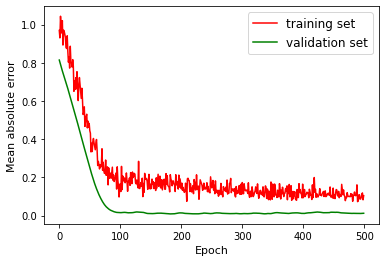

In [42]:
plt.plot(neural_model_history.history['mse'], color='r', )
plt.plot(neural_model_history.history['val_mse'], color='g')


plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [48]:
X_val = np.log(10**lcdm['log_10(M200c)'].values)
X_val_sc = xscaler.transform(X_val.reshape(-1,1))
ypred_sc = neural_model.predict(X_val_sc)
ypred = yscaler.inverse_transform(ypred_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

1/1 [==============================] - 0s 13ms/step
Traning and Testing on raw data, all features 



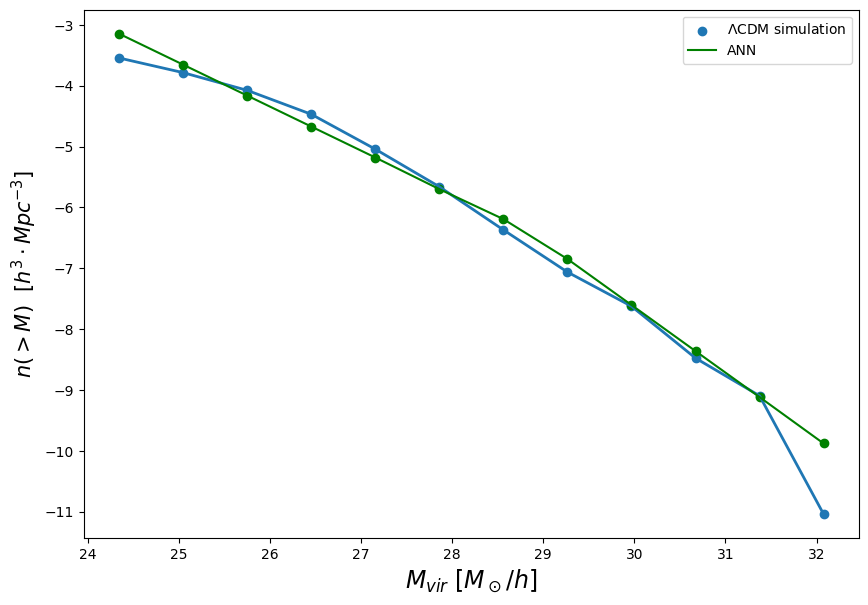

In [50]:
plt.figure(figsize=(10, 7), dpi=100)

# plt.yscale('log')
# plt.xscale('log')

plt.plot(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), linewidth=2)
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation')

plt.scatter(X_val, ypred, c='green')
plt.plot(X_val, ypred, c='green', label='ANN')


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

# plt.xlim([3.e10,2.e14])
# plt.ylim([1.e-6,1.e-1])
plt.legend()
plt.savefig('HMF_SFDM_extended.png')
plt.show()